___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [11]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from tqdm.notebook import tqdm
import datetime
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [12]:
# from fontsetting import font_cmu
# plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [14]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None, augment=False):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.augment = augment
        self.original_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
        self.num_original_images = len(self.original_filenames)

        self.low_res_images = []
        self.high_res_images = []

        for filename in self.original_filenames:
            high_res_path = os.path.join(self.high_res_dir, filename)
            low_res_path = os.path.join(self.low_res_dir, filename)

            # Load original images
            try:
                hr_img = Image.open(high_res_path)
                lr_img = Image.open(low_res_path)
            except Exception as e:
                print(f"Error loading image {filename}: {e}")
                continue

            # Resize low-res to 128x128
            lr_img = lr_img.resize((128, 128), Image.BICUBIC)

            original_lr, original_hr = lr_img, hr_img
            processed_lr = []
            processed_hr = []

            if self.augment:
                # --- Apply transformations ---
                # 1) Original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)
                # 2) Rotated by 90 degrees
                processed_lr.append(original_lr.rotate(90))
                processed_hr.append(original_hr.rotate(90))
                # 3) Rotated by 180 degrees
                processed_lr.append(original_lr.rotate(180))
                processed_hr.append(original_hr.rotate(180))
                # 4) Rotated by 270 degrees
                processed_lr.append(original_lr.rotate(270))
                processed_hr.append(original_hr.rotate(270))

                # Apply flips
                lr_v_flip = original_lr.transpose(Image.FLIP_LEFT_RIGHT)
                hr_v_flip = original_hr.transpose(Image.FLIP_LEFT_RIGHT)
                lr_h_flip = original_lr.transpose(Image.FLIP_TOP_BOTTOM)
                hr_h_flip = original_hr.transpose(Image.FLIP_TOP_BOTTOM)

                # 5) Mirrored on the vertical axis (Flip Left/Right)
                processed_lr.append(lr_v_flip)
                processed_hr.append(hr_v_flip)
                # 6) Mirrored on the horizontal axis (Flip Top/Bottom)
                processed_lr.append(lr_h_flip)
                processed_hr.append(hr_h_flip)

                # Apply flips combined with rotation (unique combinations)
                # 7) Rotated by 90 degrees and mirrored on the vertical axis
                processed_lr.append(lr_v_flip.rotate(90))
                processed_hr.append(hr_v_flip.rotate(90))
                # 8) Rotated by 90 degrees and mirrored on the horizontal axis
                processed_lr.append(lr_h_flip.rotate(90))
                processed_hr.append(hr_h_flip.rotate(90))
            else:
                # If not augmenting, just use the original
                processed_lr.append(original_lr)
                processed_hr.append(original_hr)

            # Apply the final transform (ToTensor) and store
            if self.transform:
                for lr, hr in zip(processed_lr, processed_hr):
                    self.low_res_images.append(self.transform(lr))
                    self.high_res_images.append(self.transform(hr))
            else:
                 # If no transform, store PIL images (not recommended for training/eval)
                self.low_res_images.extend(processed_lr)
                self.high_res_images.extend(processed_hr)

    # Get the number of samples in the dataset (original or augmented)
    def __len__(self):
        return len(self.low_res_images)

    # Get the sample at the given index
    def __getitem__(self, idx):
        # Return pre-processed tensors
        return self.low_res_images[idx], self.high_res_images[idx]

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images WITH augmentation
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform, augment=True)
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform, augment=False)

# Function to create data loader
def create_loader(dataset, batch_size, shuffle_data=True): # Added shuffle parameter
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data)

### Create a custom loss class to easily implement custom loss functions.

In [15]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha # Weight for MSE (PSNR) loss
        self.beta = beta # Weight for SSIM loss
        self.mse = nn.MSELoss()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        self.device = device

    def forward(self, y_pred, y_true):
        # Ensure inputs are on the same device as the ssim metric
        y_pred = y_pred.to(self.device)
        y_true = y_true.to(self.device)

        # Calculate MSE Loss
        mse_loss = self.mse(y_pred, y_true)

        # Calculate SSIM Loss (1 - SSIM, as SSIM higher is better)
        ssim_val = self.ssim(y_pred, y_true)
        ssim_loss = 1.0 - ssim_val

        # Combine losses
        combined_loss = (self.alpha * mse_loss) + (self.beta * ssim_loss)

        return combined_loss

___
### Define a super-resolution network

#### Here, I have defined a trivial network, which has only two layers and no activation function. We are essentially doing linear filtering.

In [16]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)  # First conv layer
        x = self.conv2(x)  # Output layer
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [17]:
# Helper function for one training epoch

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train() # Set model to training mode
    total_train_loss = 0.0
    for x_tr_batch, y_tr_batch in train_loader:
        x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

        # Upsample low-resolution input
        x_tr_batch_up = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

        optimizer.zero_grad()
        y_hat_tr_batch = model(x_tr_batch_up)
        loss = criterion(y_hat_tr_batch, y_tr_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

# Helper function for one validation epoch

def validate_one_epoch(model, val_loader, criterion, psnr_metric, ssim_metric, device):
    model.eval() # Set model to evaluation mode
    total_val_loss = 0.0
    total_val_psnr = 0.0
    total_val_ssim = 0.0
    num_samples = 0

    with torch.no_grad():
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            batch_size = x_val_batch.size(0)
            num_samples += batch_size

            # Upsample low-resolution input
            x_val_batch_up = torch.nn.functional.interpolate(x_val_batch, scale_factor=2, mode='bicubic', align_corners=False)

            y_hat_val_batch = model(x_val_batch_up)
            val_loss = criterion(y_hat_val_batch, y_val_batch)
            total_val_loss += val_loss.item() * batch_size # Accumulate total loss

            # Calculate metrics (ensure batch dimension is present)
            psnr = psnr_metric(y_hat_val_batch, y_val_batch)
            ssim = ssim_metric(y_hat_val_batch, y_val_batch)
            total_val_psnr += psnr.item() * batch_size
            total_val_ssim += ssim.item() * batch_size

    avg_val_loss = total_val_loss / num_samples # Average loss per image
    avg_val_psnr = total_val_psnr / num_samples
    avg_val_ssim = total_val_ssim / num_samples
    avg_val_score = avg_val_psnr + (40 * avg_val_ssim)

    return avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim

def train_model(model, opt, criterion, scheduler, train_loader, val_loader, num_epoch, patience, device, save_dir='saved_models'):
    os.makedirs(save_dir, exist_ok=True)
    epoch_nums, avg_train_losses, avg_val_losses, avg_val_scores = [], [], [], []
    best_val_score = -float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Initialize metrics outside the loop - ensure they handle accumulation correctly or reset them if needed
    # For torchmetrics, calling them per batch and averaging manually is often safer than relying on internal state across epochs.
    # We will re-initialize inside validate_one_epoch for clarity here.
    psnr_metric = PeakSignalNoiseRatio().to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device) # data_range=1.0 assumes normalization

    overall_pbar = tqdm(range(num_epoch), desc="Overall Training Progress")

    for epoch in overall_pbar:
        # --- Training ---
        avg_train_loss = train_one_epoch(model, train_loader, criterion, opt, device)

        # --- Validation ---
        avg_val_loss, avg_val_score, avg_val_psnr, avg_val_ssim = validate_one_epoch(
            model, val_loader, criterion, psnr_metric, ssim_metric, device
        )

        # Store metrics for plot
        epoch_nums.append(epoch + 1)
        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)
        avg_val_scores.append(avg_val_score)

        # --- Update Progress Bar ---
        current_lr = opt.param_groups[0]['lr']
        overall_pbar.set_description(
            f"Epoch {epoch+1}/{num_epoch} | LR: {current_lr:.1e} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Score: {avg_val_score:.2f}"
        )

        # --- Learning Rate Scheduler Step ---
        scheduler.step(avg_val_score)

        # --- Checkpointing and Early Stopping ---
        if avg_val_score > best_val_score:
            best_val_score = avg_val_score
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            # Optionally add a print statement here if desired
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

    # --- Save Best Model ---
    if best_model_state:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        score_str = f"{best_val_score:.2f}".replace('.', 'p')
        filename = f"best_model_score_{score_str}_time_{timestamp}.pth"
        save_path = os.path.join(save_dir, filename)
        torch.save(best_model_state, save_path)
        print(f"\nTraining finished. Best model saved to '{save_path}' with score: {best_val_score:.2f}")
        model.load_state_dict(best_model_state) # Load best state into model
    else:
        print("\nTraining finished. No model state was saved.")

    # --- Final Plot ---
    fig_final, ax1_final = plt.subplots(figsize=(10, 6))
    ax2_final = ax1_final.twinx()
    line1_final, = ax1_final.plot(epoch_nums, avg_train_losses, 'r-', label='Training Loss')
    line2_final, = ax1_final.plot(epoch_nums, avg_val_losses, 'r--', label='Validation Loss')
    line3_final, = ax2_final.plot(epoch_nums, avg_val_scores, 'b-', label='Validation Score')
    ax1_final.set_xlabel('Epochs')
    ax1_final.set_ylabel('Loss', color='tab:red')
    ax1_final.tick_params(axis='y', labelcolor='tab:red')
    ax2_final.set_ylabel('Validation Score (PSNR + 40*SSIM)', color='tab:blue')
    ax2_final.tick_params(axis='y', labelcolor='tab:blue')
    ax1_final.legend(handles=[line1_final, line2_final], loc='upper left')
    ax2_final.legend(handles=[line3_final], loc='upper right')
    ax1_final.grid(True)
    plt.title('Final Training Progress')
    fig_final.tight_layout()
    plt.show()

    return best_val_score

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Number of original training images: 240
Number of training images after augmentation: 1920
Number of original validation images: 30
Number of validation images (no augmentation): 30


Overall Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]


Early stopping triggered after 15 epochs with no improvement.

Training finished. Best model saved to 'saved_models\best_model_score_70p94_time_20250421_171042.pth' with score: 70.94


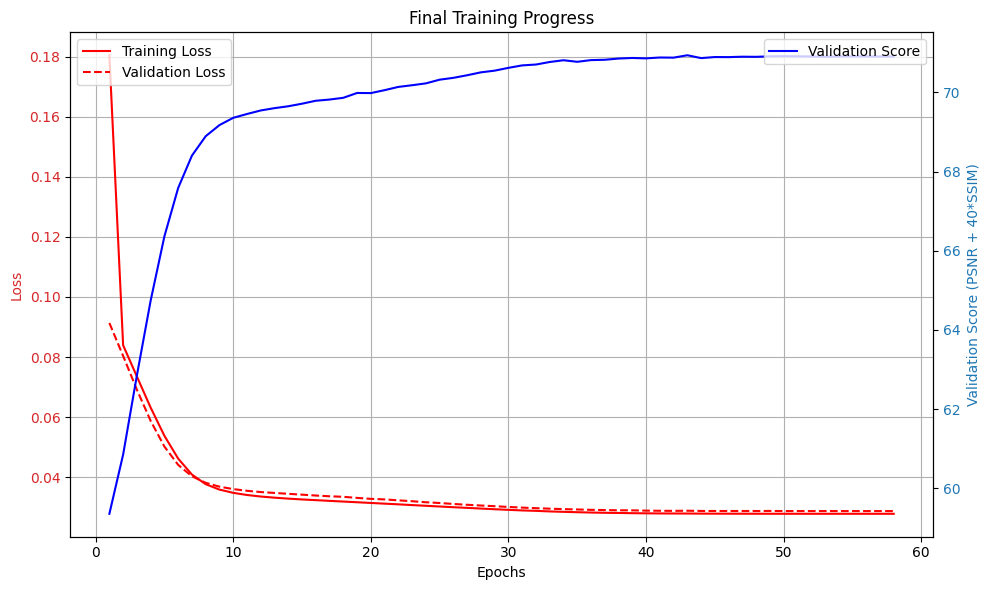


Best validation score achieved during training: 70.94


In [18]:
# --- Hyperparameters ---
batch_size = 10
lr = 1e-4
num_epoch = 200
patience_early_stopping = 15
scheduler_patience = 5
scheduler_factor = 0.1
loss_alpha = 0.5
loss_beta = 0.5
save_dir = 'saved_models'

# --- Setup ---
# Create DataLoaders
train_loader = create_loader(train_dataset, batch_size, shuffle_data=True)
val_loader = create_loader(val_dataset, batch_size, shuffle_data=False) # Ensure val_dataset is defined

# Print dataset sizes (assuming datasets are defined)
if 'train_dataset' in locals() and 'val_dataset' in locals():
    print(f'Number of original training images: {getattr(train_dataset, "num_original_images", "N/A")}')
    print(f'Number of training images after augmentation: {len(train_dataset)}')
    print(f'Number of original validation images: {getattr(val_dataset, "num_original_images", "N/A")}')
    print(f'Number of validation images (no augmentation): {len(val_dataset)}')

# Model
model = TrivialNet().to(device)

# Optimizer
opt = optim.Adam(model.parameters(), lr=lr)

# Loss Function (Criterion)
criterion = CombinedLoss(alpha=loss_alpha, beta=loss_beta, device=device).to(device)

# Learning Rate Scheduler - Removed verbose=True
scheduler = ReduceLROnPlateau(
    opt,
    mode='max',
    factor=scheduler_factor,
    patience=scheduler_patience
    # verbose=False # Or simply omit the verbose argument
)

# --- Train the model ---
best_score = train_model(
    model=model,
    opt=opt,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epoch=num_epoch,
    patience=patience_early_stopping,
    device=device,
    save_dir=save_dir
)

print(f"\nBest validation score achieved during training: {best_score:.2f}")

___
### Apply it one of the validation image

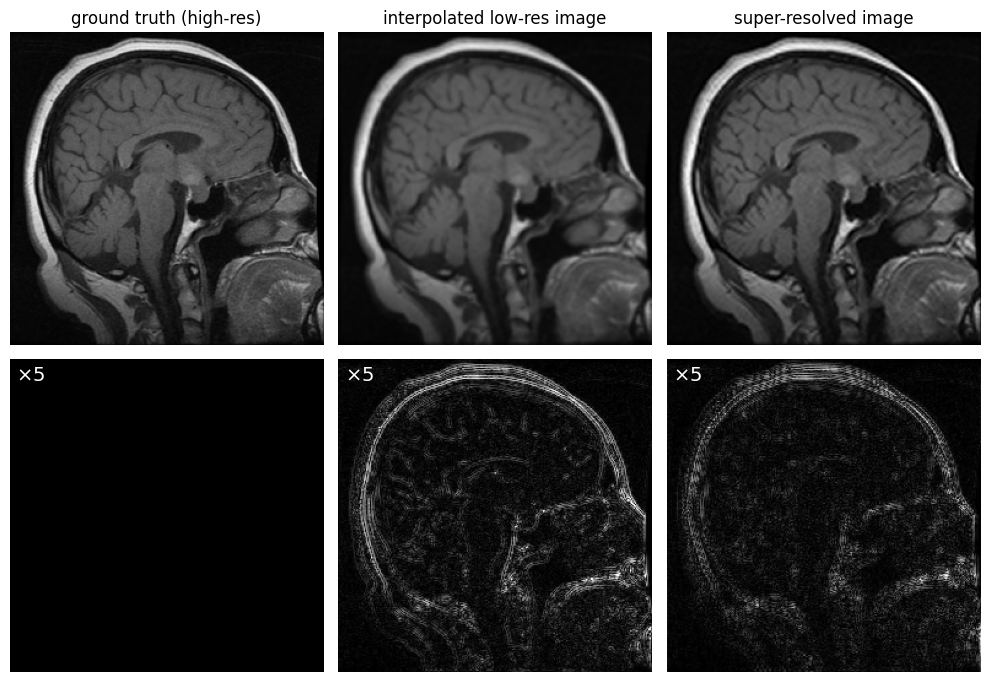

In [19]:
# Load one (low-res, high-res) image pair from validation dataset and move it to the dedvice
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()

### Compute PSNR and SSIM over the entire validation dataset

In [20]:
def evaluate_model(model, data_loader, device):
    """Computes PSNR, SSIM, and Score over a dataset using a DataLoader."""
    model.eval() # Set model to evaluation mode
    psnr_metric = PeakSignalNoiseRatio().to(device)
    # Initialize SSIM with fixed data_range=1.0, assuming normalization [0, 1]
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    total_psnr_sr = 0.0
    total_ssim_sr = 0.0
    total_psnr_interp = 0.0
    total_ssim_interp = 0.0
    num_samples = 0

    with torch.no_grad():
        # Use tqdm for progress if dataset is large
        eval_pbar = tqdm(data_loader, desc="Evaluating Model")
        for x_batch, y_batch in eval_pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            batch_size_actual = x_batch.size(0) # Use actual batch size
            num_samples += batch_size_actual

            # Upsample low-res image (Input to model and baseline)
            x_batch_up = torch.nn.functional.interpolate(x_batch, scale_factor=2, mode='bicubic', align_corners=False)

            # Get model prediction
            y_hat_batch = model(x_batch_up)

            # Calculate metrics for super-resolved
            psnr_sr = psnr_metric(y_hat_batch, y_batch)
            ssim_sr = ssim_metric(y_hat_batch, y_batch) # Use fixed data_range
            total_psnr_sr += psnr_sr.item() * batch_size_actual
            total_ssim_sr += ssim_sr.item() * batch_size_actual

            # Calculate metrics for interpolated (baseline)
            psnr_interp = psnr_metric(x_batch_up, y_batch)
            ssim_interp = ssim_metric(x_batch_up, y_batch) # Use fixed data_range
            total_psnr_interp += psnr_interp.item() * batch_size_actual
            total_ssim_interp += ssim_interp.item() * batch_size_actual

    # Calculate averages
    avg_psnr_sr = total_psnr_sr / num_samples
    avg_ssim_sr = total_ssim_sr / num_samples
    avg_psnr_interp = total_psnr_interp / num_samples
    avg_ssim_interp = total_ssim_interp / num_samples

    # Calculate scores
    avg_score_sr = avg_psnr_sr + (40 * avg_ssim_sr)
    avg_score_interp = avg_psnr_interp + (40 * avg_ssim_interp)

    # Print results
    print("\n--- Final Evaluation Results ---")
    print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
    print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
    print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
    print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')
    print(f'Average Score (interpolated): {avg_score_interp:.2f}')
    print(f'Average Score (super-resolved): {avg_score_sr:.2f}')

    return avg_score_sr, avg_score_interp


# --- Call the Evaluation Function ---
final_sr_score, final_interp_score = evaluate_model(model, val_loader, device)

Evaluating Model:   0%|          | 0/3 [00:00<?, ?it/s]


--- Final Evaluation Results ---
Average PSNR (interpolated): 31.01 dB
Average PSNR (super-resolved): 33.22 dB
Average SSIM (interpolated): 0.9074
Average SSIM (super-resolved): 0.9429
Average Score (interpolated): 67.30
Average Score (super-resolved): 70.94
